In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

In [2]:
# helper function for visualize
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


def dimension_reduce_TSNE(embeds):
    tsne2d = TSNE(n_components=2)
    embeds_2d = tsne2d.fit_transform(embeds)
    return embeds_2d

In [3]:
def plot2D_by_category(X_2d, Y, num2plot=None, with_legend=False):
    assert len(X_2d) == len(Y), f"label Y not match data X_2d in size: {len(Y)} != {len(X_2d)}"
    category_names = list(set(Y))
    print(f"Total {len(Y)} of {len(category_names)} category.")
    if num2plot is not None:
        category_names = category_names[:num2plot]
        print(f"only plot {len(category_names)} class")
    colors = [np.random.rand(3,) for i in category_names]
    plt.figure(figsize=(8, 8))
    for color, target_name in zip(colors, category_names):
        cluster_ids = [i for i, name in enumerate(Y) if name == target_name]
        plt.scatter(X_2d[cluster_ids, 0], X_2d[cluster_ids, 1], color=color, lw=2, label=target_name)
    plt.title("speaker audio slices embedding 2D visualize")
    if with_legend:
        plt.legend(loc='best')
    plt.show()

#### Load Data

In [4]:
# got kaldi format metadata for testset
from eend import kaldi_data
DATA_BASE="data/npr/dev.2spk.8k"

data_obj = kaldi_data.KaldiData(DATA_BASE)
# exist attribute for kaldi data object
# - segments (Dict[str, List[Dict]]): {recid: [{'utt': str, 'st': float, 'et': float}]}
# - utt2spk (Dict[str, str]): {uttid: 'str of all speakers id'}
# - wavs (Dict[str, str]): {recid: audio_file_name}
# - reco2dur (Dict[str, float]): {recid: duration_in_second}
# - spk2utt (Dict[str, List[str]]): {spkid: [uttid]}

In [6]:
from tqdm import tqdm
from resemblyzer import preprocess_wav, VoiceEncoder

def load_kaldi_wavs(kaldi_data_obj, base_dir=DATA_BASE):
    """Load and preprocessing wavs indicated in kaldi meta data object."""
    wavs = {}
    for recid, audio_basename in tqdm(kaldi_data_obj.wavs.items(), "Preprocessing wavs", len(kaldi_data_obj.wavs), unit=" wavs"):
        #audio_path = os.path.join(base_dir, audio_basename)
        wav = preprocess_wav(audio_basename)
        wavs[recid] = wav
    return wavs

loaded_wavs = load_kaldi_wavs(data_obj)

Preprocessing wavs: 100%|██████████| 157/157 [08:08<00:00,  3.11s/ wavs]


In [7]:
def embedding_wavs(preprocessed_wavs, num_trim=None, rate=2):
    """Embed wavs using resemblyzer VoiceEncoder.

    Args:
        num_trim (int): only return this many wavs;
        rate (int): slice wavs this many utterance per second.
    """
    encoder = VoiceEncoder()
    wav_embeddings = {}
    for i, (recid, audio_wav) in enumerate(preprocessed_wavs.items()):
        if num_trim is not None and i >= num_trim:
            break
        embed, partial_embeds, wav_slices = encoder.embed_utterance(audio_wav, return_partials=True, rate=rate)
        wav_embeddings[recid] = {
            "global": embed, "partials": partial_embeds, "slices": wav_slices
        }
    return wav_embeddings

wav_embeddings = embedding_wavs(loaded_wavs)

Loaded the voice encoder model on cuda in 4.14 seconds.


### Plot wavs

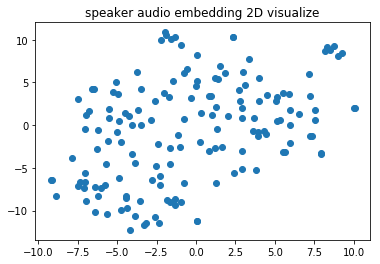

In [8]:
# Plot record level embeddings
def simple_2Dplot(embeds):
    plt.figure()
    plt.scatter(embeds[:, 0], embeds[:, 1])
    plt.title("speaker audio embedding 2D visualize")
    plt.show()


def extract_record_embeddings(wav_embeds):
    recids, embs = [], []
    for i, (rid, res) in enumerate(wav_embeds.items()):
        emb = res['global']
        recids.append(rid)
        embs.append(emb)
    embs_np = np.stack(embs)
    return embs_np, recids

record_embs_np, record_embs_rids = extract_record_embeddings(wav_embeddings)
record_embs_np_2D = dimension_reduce_TSNE(record_embs_np)
simple_2Dplot(record_embs_np_2D)

Total 157 of 157 category.


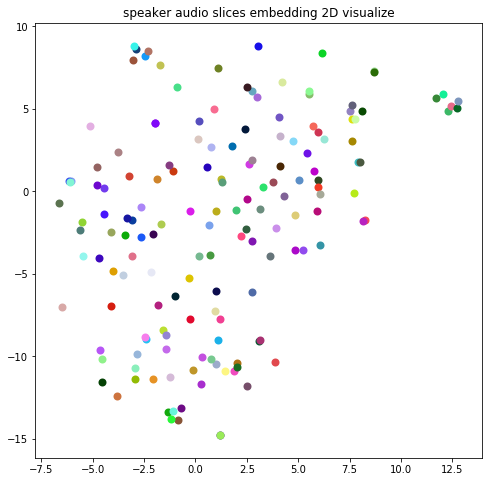

In [10]:
# Plot slice level embeddings
def extract_record_slices_embeddings(wav_embeds, num_trim=None):
    recids, embs = [], []
    for i, (rid, res) in enumerate(wav_embeds.items()):
        # if num_trim is not None and i >= num_trim:
        #     break
        partials_emb = res['partials']
        n_partials = len(partials_emb)
        recids.extend([rid for _ in range(n_partials)])
        embs.append(partials_emb)
    embs_np = np.concatenate(embs)
    return embs_np, recids

slices_embs_np, slices_embs_rids = extract_record_embeddings(wav_embeddings)
slices_embs_np_2D = dimension_reduce_TSNE(slices_embs_np)
plot2D_by_category(slices_embs_np_2D, slices_embs_rids)


Total 157 of 157 category.
only plot 100 class


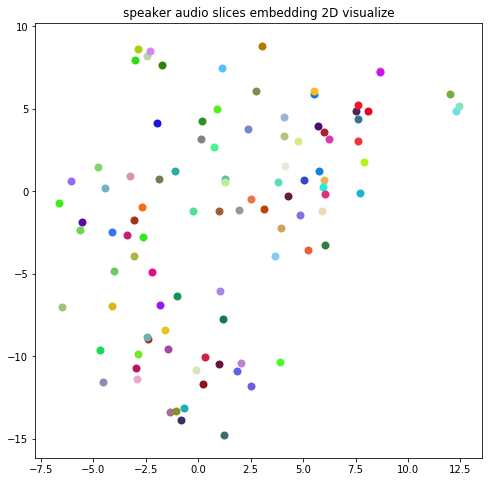

In [12]:
plot2D_by_category(slices_embs_np_2D, slices_embs_rids, num2plot=100)

In [ ]:
# embs, label = embedding_wavs(wavs)
# embs_2D = dimension_reduce_TSNE(embs)
# plot(embs_2D, label)